Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [ ]:
### комментарии для кода на английском для краткости
## a list of abbreviations used in the variable names
# df   = dataframe
# ctt  = contingency table
# n    = number
# usr  = users
# slv  = solvents

## import libraries
## data manipulation
import pandas as pd
import numpy as np
from math import exp

## statistics
from scipy.stats import chisquare, chi2, chi2_contingency
from scipy.stats import ttest_1samp

## data visualization
import matplotlib.pyplot as plt
import seaborn as sns

### set default options
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

### import data
path = './problem2.csv'
df = pd.read_csv(path, sep=';')

### data check 
# df.head()
# df.isna().sum()
# df.describe()
# df.user_id.nunique() == df.shape[0]

### data preparation
## add a column classifying users as solvent or not
df['solvent'] = df.revenue > 0

#### Анализ I
Для начала хорошо бы узнать как аукционы повлияли на распределение платящих пользователей (далее клиенты).\
Для этого, имея две номинативные переменных, и бинарный ответ, используем Хи-квадрат

In [2]:
# calcaulte a contingency table to see how many solvents are in each group
df_ctt = pd.crosstab(index=df.testgroup, columns=df.solvent)
print(df_ctt)

solvent     False  True 
testgroup               
a          200175   1928
b          200862   1805


In [3]:
# check percent of sovlents within each test group
df_ctt.iloc[:,1]/(df_ctt.iloc[:,0]+df_ctt.iloc[:,1])*100

testgroup
a    0.953969
b    0.890624
dtype: float64

In [4]:
# apply the Chi2 test with automatical caclulation of the expected values and the Yates correction 
stat, p, dof, expected = chi2_contingency(pd.crosstab(index=df.testgroup, columns=df.solvent))
print('Chi2 = {} \np = {}'.format(round(stat,3),round(p,3)))

Chi2 = 4.375 
p = 0.036


#### Вывод I
Не смотря на статистически значимомое различие кол-ва клиентов от ожидаемых значение, абсолютная разница между процентами клиентов в контрольной и тестовой группах ~ -0.06%.\
Из результата невозможно сделать достаточно надежных выводов.\
Нужно явно идти дальше.

#### Анализ II
Посмотрим как аукционы повлияли на доход.\
До определения нужных метрик, посмотрим на распределение клиентов в каждой группе.

In [5]:
# select solvents
df_slv = df.query('solvent == True')

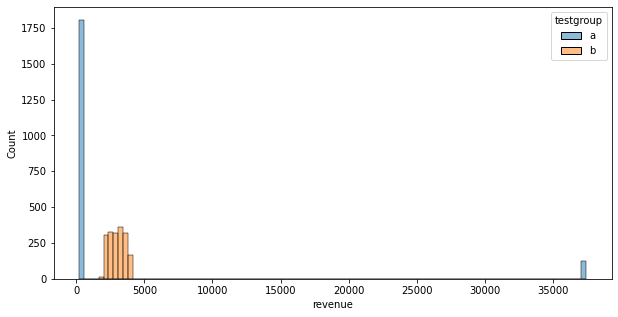

In [6]:
sns.histplot(data=df_slv, x='revenue', hue='testgroup')

In [7]:
# descriptive statistics for the outliyers in the control group
df_slv.query('testgroup == "a" and revenue > 10000').revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

In [8]:
# descriptive statistics for the the control group without outliyers
df_slv.query('testgroup == "a" and revenue < 10000').revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [9]:
# descriptive statistics for the test group
df_slv.query('testgroup == "b"').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

#### Вывод II
В контрольной группе наблюдается 123 (6%) клиентов из 1928, которые принесли в среднем 37319 ± 25(sd) рубля.\
Остальные 1805 (94%) клиентов принесли в среднем 303 ± 58(sd) рубля.\
Разделим клиентов на выделяющихся и умеренных.

Посмотрим на выделяющихся клиентов, а затем сделаем два анализа.
- С исключенем выделяющихся пользователей
- Без исключения сильно выделяющихся пользователей

#### Анализ III.1 
Исключим выделяющихся пользователей

In [9]:
# check percent of moderate sovlents within each test group
df_ctt = pd.crosstab(index=df[df['revenue']<10000].testgroup, columns=df.solvent)
df_ctt2.iloc[:,1]/(df_ctt.iloc[:,0]+df_ctt.iloc[:,1])*100

testgroup
a    0.893653
b    0.890624
dtype: float64

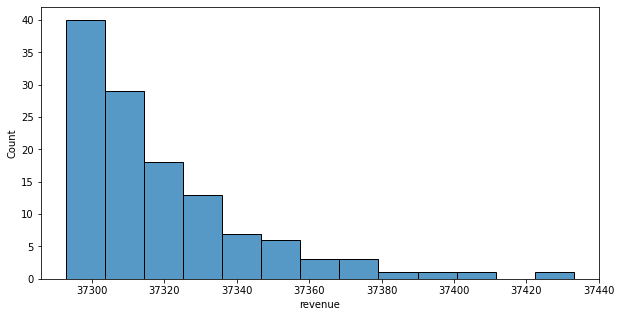

In [67]:
# distribution of the outliers
sns.histplot(data=df_slv.query('testgroup == "a" and revenue > 10000'), x='revenue')

In [19]:
# check how much income (%) the outliers brought comparing to the whole income in the control group
df_slv.query('testgroup == "a" and revenue > 10000').revenue.sum()/df_slv.query('testgroup == "a"').revenue.sum()

0.8937077665950377

In [18]:
# remove the outliers 
df_slv_eq = df_slv.query('revenue < 10000')

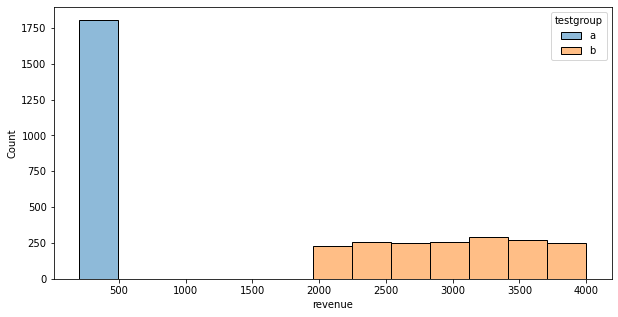

In [63]:
sns.histplot(data=df_slv_eq, x='revenue', hue='testgroup')

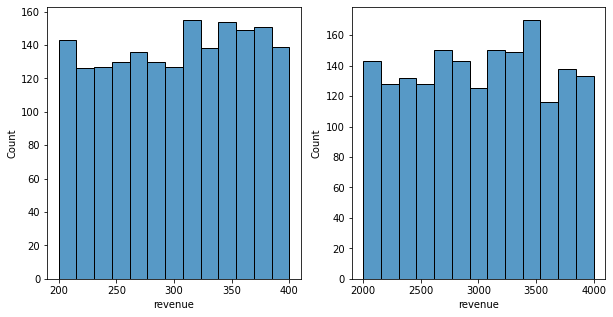

In [39]:
# zoom by splitting
fig, ax = plt.subplots(ncols=2)
sns.histplot(ax=ax[0], data=df_slv_eq[df_slv_eq['testgroup'] == 'a'], x='revenue')
sns.histplot(ax=ax[1], data=df_slv_eq[df_slv_eq['testgroup'] == 'b'], x='revenue')

#### Вывод III.1
Разница в 0.06% количества клиентов заключается в отсутствии выделяющихся клиентов в тестовой группе. Выделяющиеся клиентов имеют ненормальное распределение. Они принесли 90% от общего дохода в контрольной группе. Данные клиентов должны быть изучены отдельно с использованием большего кол-ва данных о них.

Наблюдается заметная разница между группами умеренных клиентов, но внутри каждой группы распределения равномерные.\
Заметно, что медиана, минимальное и средние значения почти в 10 раз больше в тестовой группе.\
Т.к. распределения не перекрываются и минимальное значение тестовой группы в 5 раз больше максимального значения контрольной группы, маловероятно, что они статитически НЕ различимы.\
Соответственно, статистический тест на разницу распределений не требуется.

Из-за равномерности распределений нужно смотреть на распределение целиком. 

Для оценки воздействия аукционов на прибыль посмотрим на отношения всех 10-х перцентилей, а также отношение сумарных доходов обеих груп.

In [23]:
perc_a = np.percentile(df_slv_eq.query('testgroup == "a"').revenue, 
                       [i for i in range(10,100,10)])
perc_b = np.percentile(df_slv_eq.query('testgroup == "b"').revenue, 
                       [i for i in range(10,100,10)])

In [82]:
# percentile ratio
perc_b/perc_a

array([9.99274047, 9.95041322, 9.97870722, 9.89507042, 9.90819672,
       9.88      , 9.89534884, 9.86592798, 9.98894737])

In [83]:
# mean percentile ratio
np.mean(perc_b/perc_a)

9.9283724718512

In [84]:
# income ratio
df_slv_eq.query('testgroup == "b"').revenue.sum()/df_slv_eq.query('testgroup == "a"').revenue.sum()

9.930821688216772

#### Вывод II.1
- Введение аукционов привело к незначительному снижению количества клиентов.\
Однако, это произошло за счет исключения 123-х выделяющихся клиентов, который принесли 90% дохода в контрольной группе. Требуется дополнительный анализ таких клиентов. Необходимо узнать, почему они не попали в тестовую группу. Данные клиентов имеют огромную ценность, т.к. незначительное их количество может значительно увеличить прибыльность приложения.  

- Без учета этих клиентов, аукционы привели к сдвигу и мастшабированию распределения умеренных клиентов.
Данные по доходу на клиента:\
Контрольная группа: минимальное 200р, медианное 305р и максимальное 400р.\
Тестовая группа: минимальное 2000р, медианное 3022р и максимальное 4000р. 
Очевидно, что медианный доход на умеренно платящего клиента  увеличился в 10 раз.

#### Анализ III.2 
Сравним всех пользователей без исключения.

Из-за ненормальности распределений, сравнивать будем медианное значение дохода на клиента используя Bootstrap

In [28]:
df_slv[df_slv['testgroup']=='a'].revenue.max()

37433

In [29]:
df_slv[df_slv['testgroup']=='b'].revenue.max()

4000

In [30]:
# variable to store the median difference
med_diff = []
for _ in range(1000):
    rand_cont = np.random.choice(df_slv[df_slv['testgroup']=='a'].revenue, 200, replace=True)
    rand_test = np.random.choice(df_slv[df_slv['testgroup']=='b'].revenue, 200, replace=True)
    med_diff.append(np.median(rand_test) - np.median(rand_cont))
    

Медианная разница 2709.265
95% CI для средней разницы медиан [2704.69, 2713.84]


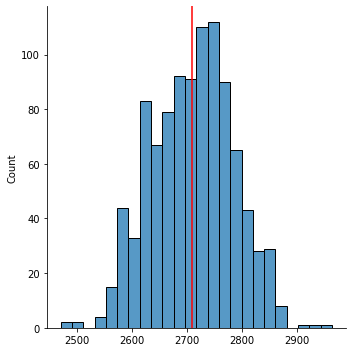

In [46]:
avg_med_diff = np.mean(med_diff)
CI1 = round(avg_med_diff - 1.96*np.std(med_diff)/(len(med_diff))**(1/2),2)
CI2 = round(avg_med_diff + 1.96*np.std(med_diff)/(len(med_diff))**(1/2),2)
sns.displot(med_diff)
plt.axvline(avg_med_diff, 0, 100, color='red')
print('Медианная разница {}'.format(avg_med_diff))
print('95% CI для средней разницы медиан [{}, {}]'.format(CI1,CI2))

#### Вывод II.2
С учетом всех пользователей, ввод аукционов привел к медианному увеличению прибыли от клиента на 2709р, даже не смотря на то, что в тестовой группе произошел отток выделяюзихся пользователей. 
 
### Вывод для заказчика
У нас есть все основания полагать, что ввод аукционов определенно можно проводить. 
Но необходимо выяснить взаимосвязь между аукционами и оттоком пользователей, которые принесли 90% дохода в тестовой группе. Если связь не случайна, стратегия ввода аукционов должна быть скорректирована.